## Importing libraries

In [31]:
import sys, os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import logging

## Getting the data

In [32]:
data_path = Path("../data/")
# Define data path
X_path = data_path / "ei-cherry_classification_test-image-X_training.npy"
Y_path = data_path / "ei-cherry_classification_test-image-y_training.npy"

# Load the data
X = np.load(X_path.resolve())
Y = np.load(Y_path.resolve())[:,0]

#data_shape
X.shape, Y.shape

((94, 9216), (94,))

	 Label Image==>  2


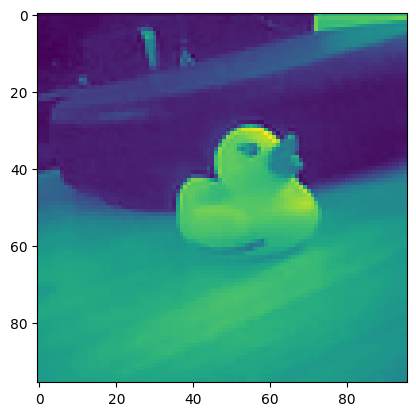

In [33]:
image = X[-1]
label = Y[-1]

print("\t Label Image==> ",label)
img = tf.reshape(image, (96,96,1)) # 32x32x3 channels
plt.imshow(img);

In [34]:
SPECIFIC_INPUT_SHAPE = (96, 96, 1)
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "cherry", "duckie" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [35]:
Dropout?

Init signature: Dropout(rate, noise_shape=None, seed=None, **kwargs)
Docstring:     
Applies dropout to the input.

The `Dropout` layer randomly sets input units to 0 with a frequency of
`rate` at each step during training time, which helps prevent overfitting.
Inputs not set to 0 are scaled up by `1 / (1 - rate)` such that the sum over
all inputs is unchanged.

Note that the `Dropout` layer only applies when `training` is set to `True`
in `call()`, such that no values are dropped during inference.
When using `model.fit`, `training` will be appropriately set to `True`
automatically. In other contexts, you can set the argument explicitly
to `True` when calling the layer.

(This is in contrast to setting `trainable=False` for a `Dropout` layer.
`trainable` does not affect the layer's behavior, as `Dropout` does
not have any variables/weights that can be frozen during training.)

Args:
    rate: Float between 0 and 1. Fraction of the input units to drop.
    noise_shape: 1D integer tensor

In [36]:

# model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
# This is only required for some input types, e.g. images

train_dataset = train_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


Epoch 1/10
3/3 - 1s - 190ms/step - accuracy: 0.6000 - loss: 1.5069 - val_accuracy: 0.7895 - val_loss: 0.5403
Epoch 2/10
3/3 - 0s - 37ms/step - accuracy: 0.6267 - loss: 0.6159 - val_accuracy: 0.3158 - val_loss: 0.7662
Epoch 3/10
3/3 - 0s - 37ms/step - accuracy: 0.6400 - loss: 0.6483 - val_accuracy: 0.7895 - val_loss: 0.4516
Epoch 4/10
3/3 - 0s - 37ms/step - accuracy: 0.6400 - loss: 0.5204 - val_accuracy: 0.7895 - val_loss: 0.4085
Epoch 5/10
3/3 - 0s - 37ms/step - accuracy: 0.6933 - loss: 0.4763 - val_accuracy: 0.8421 - val_loss: 0.3927
Epoch 6/10
3/3 - 0s - 36ms/step - accuracy: 0.8800 - loss: 0.4065 - val_accuracy: 0.9474 - val_loss: 0.4116
Epoch 7/10
3/3 - 0s - 37ms/step - accuracy: 0.9733 - loss: 0.3752 - val_accuracy: 0.8421 - val_loss: 0.3294
Epoch 8/10
3/3 - 0s - 38ms/step - accuracy: 0.9600 - loss: 0.3057 - val_accuracy: 0.8421 - val_loss: 0.2837
Epoch 9/10
3/3 - 0s - 36ms/step - accuracy: 0.9600 - loss: 0.2482 - val_accuracy: 0.9474 - val_loss: 0.2542
Epoch 10/10
3/3 - 0s - 37ms

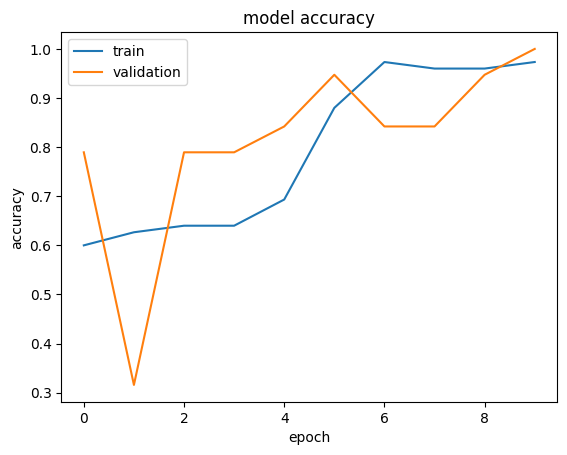

In [37]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,134,920 (27.22 MB)

 Trainable params: 2,378,306 (9.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,756,614 (18.15 MB)

In [39]:
# Save the model to disk
model_name = "test-upload.zip"
model.export(model_name)

Saved artifact at 'test-upload.zip'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  13448214864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13448216400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13448215056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360399184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360398608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360399952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6431641040: TensorSpec(shape=(), dtype=tf.float32, name=None)
  13360399376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360400720: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [45]:
import edgeimpulse as ei

# Change to an API key from your Edge Impulse project
API_KEY = "ei_bfe3a8a1b150d44148a282ff6e333487b8dee6d02b8ddc07d052a6aad136419c"
ei.API_KEY = API_KEY


In [41]:
try:
    profile = ei.model.profile(model = model, 
                               device="espressif-esp32",
                               
                              )
    print(profile.summary())
except:
    print(f"could not profile: ")

Saved artifact at '/var/folders/4q/t2hdwl4d1x340j9364kz54s0kz8_1q/T/tmp6tuw48hl/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  13448214864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13448216400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13448215056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360399184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360398608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360399952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6431641040: TensorSpec(shape=(), dtype=tf.float32, name=None)
  13360399376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360400720: TensorSpec(shape=(), dtype=tf.resource, name=None)
Target results for float32:
{
    "device": "espressif-esp32",
    

In [46]:
labels = [ "cherry", "duck"]
num_classes = len(labels)
deploy_filename = "my_model_cpp.zip"

In [47]:
# Set model information, such as your list of labels
model_output_type = ei.model.output_type.Classification(labels=labels)

# Set model input type
#model_input_type = ei.model.input_type.OtherInput()

# Create C++ library with trained model
deploy_bytes = None
try:
    
    deploy_bytes = ei.model.deploy(model=model,
                                   model_output_type=model_output_type,
                                   #model_input_type=model_input_type,
                                   deploy_target='arduino',
                                   engine='tflite')
except Exception as e:
    print(f"Could not deploy: {e}")
    
# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())

Saved artifact at '/var/folders/4q/t2hdwl4d1x340j9364kz54s0kz8_1q/T/tmpt9izr6lz/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  13448214864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13448216400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13448215056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360399184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360398608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360399952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6431641040: TensorSpec(shape=(), dtype=tf.float32, name=None)
  13360399376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13360400720: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [57]:
X[0].tofile('example.csv',sep=',',format='%10.5f')